In [5]:
!pip install scipy
!pip install ruptures


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# imports

In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt


# Dataset loading

In [2]:

filepath = './datasets/basic_motions/BasicMotions_TRAIN.arff'

def load_dataset_to_dataframe(path):
    """Load data that is stored within the path

    Args:
        path: string with path containing data
    Returns:
        A pandas dataframe with only data inside
    """
    dataset = arff.loadarff(path)
    df = pd.DataFrame(dataset[0])
    return df 

df = load_dataset_to_dataframe(filepath)

print(df.iloc[0,0].shape)

(6,)


# Clear segementation off dataset and custom change point detection 

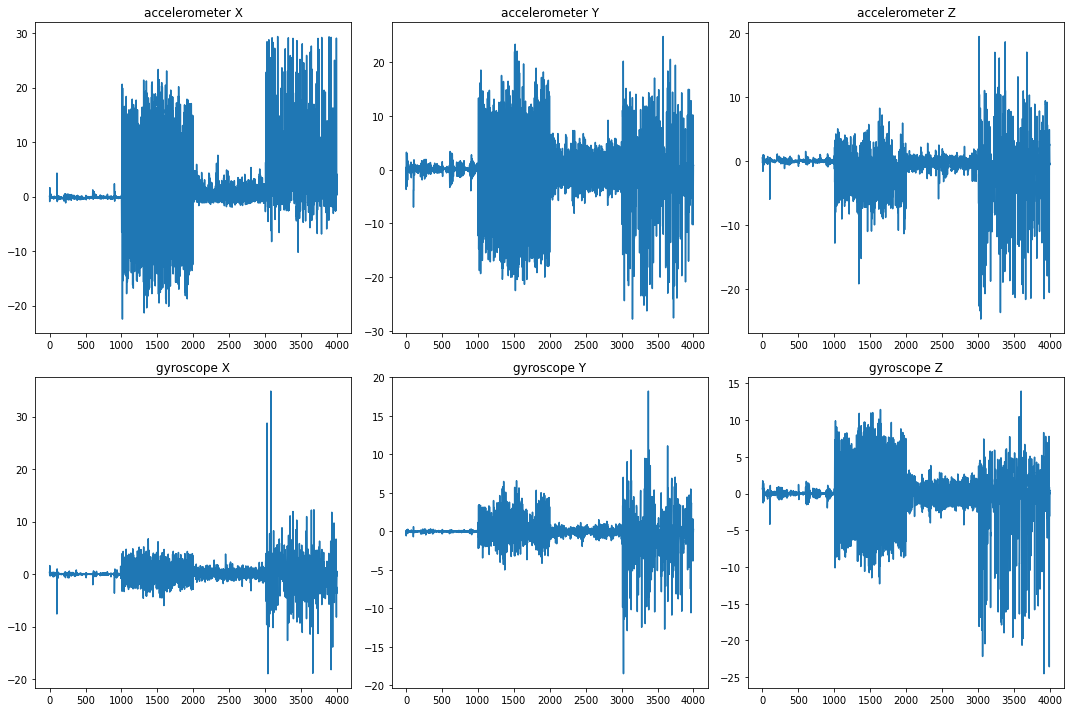

                                                   0
0  [0.079106, 0.079106, -0.903497, 1.116125, 1.63...
1  [0.394032, 0.394032, -3.666397, -0.656101, 1.4...
2  [0.551444, 0.551444, -0.282844, 0.333118, 0.39...
3  [0.351565, 0.351565, -0.095881, 1.624657, 1.18...
4  [0.02397, 0.02397, -0.319605, -0.569962, -0.27...
5  [0.633883, 0.633883, 0.972131, 1.209171, 1.739...
(4000, 6)
[[ 0.079106  0.394032  0.551444  0.351565  0.02397   0.633883]
 [ 0.079106  0.394032  0.551444  0.351565  0.02397   0.633883]
 [-0.903497 -3.666397 -0.282844 -0.095881 -0.319605  0.972131]
 ...
 [ 2.490353 -0.878765 -0.597296  0.111862 -0.117188 -0.050604]
 [ 4.12212   0.91162  -0.465409  0.535338  0.19709   0.44212 ]
 [ 3.16927   0.826934 -0.362036 -0.298298  0.250357  0.428803]]


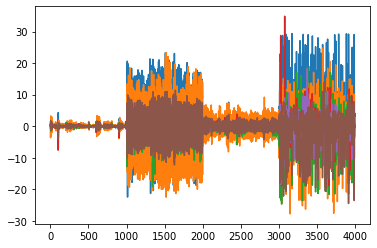

[1005, 2000, 3005, 4000]


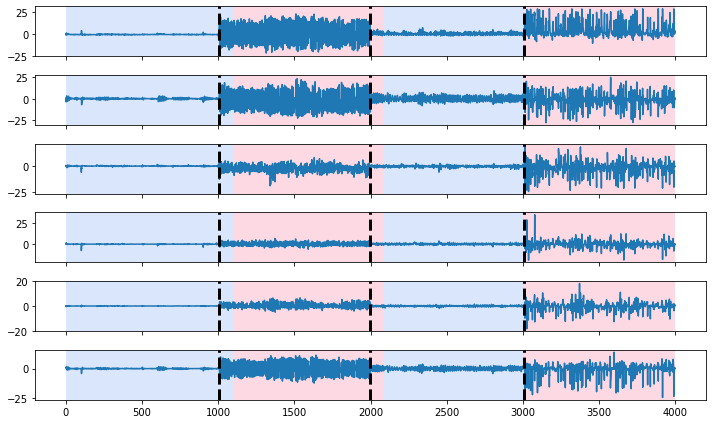

In [3]:
#print(df.iloc[0,0].shape[0])

def stack_time_series(df):
    """This function creates new dataframe without segmentation and classification

    Args:
        df: segmented dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
    """
    dimensionality = df.iloc[0,0].shape[0] # assumption that data dimensionality is the number of rows of first element in dataframe
    # also the first column is expected to store data (second stores classification)
    
    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))
    
    # filling it with empty numpy arrays
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])
    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        for r in row[0]:
             stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
             i += 1
    return stacked

def dataframe_to_ndarray(df):
    """This function creates ndarray(2 dmiensional, shape: length x dim) of dataframe (shape: dim x length)

    Args:
        df: dataframe
    Returns:
        A numpy array with shape: length x dim)
    """
    ndarray = np.array([])
    for index, row in df.iterrows():
        if index == 0:
            ndarray = row[0]
        else:
            ndarray = np.vstack((ndarray,row[0]))
    return ndarray.transpose()


stacked = stack_time_series(df)
#print(df.iloc[0,0][1])
#print(stacked)
# plt.plot(stacked.iloc[0,0])
# plt.plot(stacked.iloc[1,0])
# plt.plot(stacked.iloc[2,0])
# plt.plot(stacked.iloc[3,0])
# plt.plot(stacked.iloc[4,0])
# plt.plot(stacked.iloc[5,0])
#print(df)
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot different data on each subplot
axs[0, 0].plot(stacked.iloc[0,0])
axs[0, 0].set_title('accelerometer X')

axs[0, 1].plot(stacked.iloc[1,0])
axs[0, 1].set_title('accelerometer Y')

axs[0, 2].plot(stacked.iloc[2,0])
axs[0, 2].set_title('accelerometer Z')

axs[1, 0].plot(stacked.iloc[3,0])
axs[1, 0].set_title('gyroscope X')

axs[1, 1].plot(stacked.iloc[4,0])
axs[1, 1].set_title('gyroscope Y')

axs[1, 2].plot(stacked.iloc[5,0])
axs[1, 2].set_title('gyroscope Z')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

n, dim = 4000, 6  # number of samples, dimension
n_bkps, sigma = 3, 5  # number of change points, noise standart deviation
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)
# print((signal))
# print((signal).shape)

# plt.plot(signal)
# plt.show()
print(stacked)
motion_basics_stacked_ndarray = dataframe_to_ndarray(stacked)
print((motion_basics_stacked_ndarray).shape)
print((motion_basics_stacked_ndarray))
plt.plot(motion_basics_stacked_ndarray)
plt.show()
#signal = stacked.iloc[0,0]
# change point detection
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Window(model=model).fit(motion_basics_stacked_ndarray)

my_bkps = algo.predict(n_bkps=3)


print(my_bkps)
rpt.show.display(motion_basics_stacked_ndarray, bkps, my_bkps, figsize=(10, 6))
plt.show()

### Evaluation - https://ceur-ws.org/Vol-1226/paper31.pdf

In [42]:
print(my_bkps)
print(motion_basics_stacked_ndarray.shape[0])


def predicted_labels_vector(n,change_points):
    predicted_labels = np.zeros(n)
    predicted_labels[change_points] = 1
    return predicted_labels

#pl = predicted_labels_vector(motion_basics_stacked_ndarray.shape[0] , my_bkps)

def calculate_TP_TN_FP_FN(n, predicted_points, original_points, treshold):
    predicted_labels = predicted_labels_vector(n, predicted_points)
    original_labels = np.zeros(n)
    original_labels[original_points] = 1
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    zone_counter = np.zeros(len(predicted_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                which_point = np.argmin(np.abs(original_points - index))
                if zone_counter[which_point] == True :
                    FP+=1
                    #print(index)
                else:
                    #print(index)
                    #print(value)
                    TP+=1     
                    zone_counter[which_point] = True
        else:
            if value == 0:
                TN+=1
            else:
                #print(index)
                FP+=1

    for index , val in enumerate(zone_counter):
         if val == False:
             FN+=1

    return TP, TN, FP, FN
            
            
    

[1005, 2000, 3005, 4000]
4000


In [43]:
TP,TN,FP,FN = calculate_TP_TN_FP_FN(4000,my_bkps[:-1],np.array([1000,2000,3000]),50)


print(TP)
print(TN)
print(FP)
print(FN)

3
3703
0
0
